## Train an object detection network on boggle boards

In this notebook, I'm using the dataset from Roboflow: https://public.roboflow.ai/object-detection/boggle-boards to try and create an object detection model to extract letters from images of boggle boards.

The goal is to make a program that can play Boggle, using a picture of a board as input.

This first step is to create a model that can identify letters in a grid. We use the PyTorch and Albumentations library to build a neural network to predict bounding boxes, and eventually classify the resulting letters.

In [3]:
import os
import torch
import xml.etree.ElementTree as ET
import cv2 
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.patches as pac
import albumentations as A
from albumentations.pytorch import ToTensorV2
# from PIL import Image


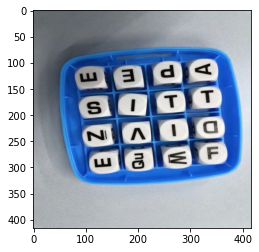

In [4]:
# have a look at the dataset
DATA_DIR = "./boggle_boards/export"

# .jpg, .xml
_files = os.listdir(DATA_DIR)
img = cv2.imread(os.path.join(DATA_DIR, _files[2])) # mod 2 = 0 index for .jpg file
plt.imshow(img);

In [5]:
def getImg(file, data_dir):
    """Read in an image file"""
    return cv2.imread(os.path.join(data_dir, file))

def getBBox(file, data_dir, format = 'coco'):
    """
    Extract bbox and label from our xml files.
    Converts to coco bbox format by default
    """
    tree = ET.parse(os.path.join(data_dir, file))
    objects = tree.getroot().findall('object')

    if format == 'pascal_voc':
    # use pascal_voc format - [x_min, y_min, x_max, y_max]
        bbox = [(
                o.find('name').text.strip(' \\'), # label
                        [
                        int(o.find('bndbox').find('xmin').text),
                        int(o.find('bndbox').find('ymin').text),
                        int(o.find('bndbox').find('xmax').text),
                        int(o.find('bndbox').find('ymax').text)
                        ] 
        ) for o in objects]
    # use coco format - [x_min, y_min, width, height]
    elif format == 'coco':
            bbox = [(
                o.find('name').text.strip(' \\'), # label
                        [
                        int(o.find('bndbox').find('xmin').text),
                        int(o.find('bndbox').find('ymin').text),
                        # width
                        int(o.find('bndbox').find('xmax').text) - int(o.find('bndbox').find('xmin').text),
                        # height
                        int(o.find('bndbox').find('ymax').text) - int(o.find('bndbox').find('ymin').text)
                        ] 
        ) for o in objects]

    return bbox

def getData(files, data_dir):

    """Imports all data in a raw dictionary format"""

    out = {}
    for file in files:
        name = file.split('.')[0]
        if name not in out.keys():
            out[name] = {'bbox':None, 'img':[]}
        if '.xml' in file:
            bb = getBBox(file, data_dir)
            out[name]['bbox'] = bb
        elif '.jpg' in file:
            img = getImg(file, data_dir)
            out[name]['img'] = img
    return out
    
def plotBB(image_key, all_data, format = 'coco'):

    """Plots image with bbox from raw data dictionary imported from getData"""

    plt.axes()
    plt.imshow(all_data[image_key]['img'].reshape(416, 416, 3))
    if format == 'pascal_voc':
        for bb in all_data[image_key]['bbox']:
                rectangle = pac.Rectangle(
                    (bb[1][0], bb[1][1]),
                    abs(bb[1][2] - bb[1][0]),
                    abs(bb[1][3] - bb[1][1]),
                    fc = 'none',
                    ec="red")
                plt.gca().add_patch(rectangle)
    elif format == 'coco':
        for bb in all_data[image_key]['bbox']:
                rectangle = pac.Rectangle(
                    (bb[1][0], bb[1][1]),
                    bb[1][2],
                    bb[1][3],
                    fc = 'none',
                    ec="red")
                plt.gca().add_patch(rectangle)
    plt.show()    

In [6]:
# get raw data
raw_data = getData(_files, DATA_DIR)


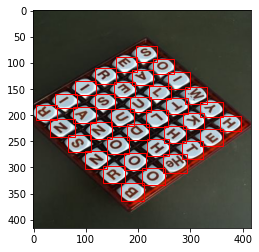

In [7]:
# plot some data with bounding boxes:
plotBB('04dcdbd29ee6e8077089edee1e924672', raw_data)

## make an object detection NNet
We have a regressor model for bounding boxes and a classification model for letters
We add the losses and run backprop

We need to develop a dataset class, dataloader class and the network.
We use this as a guide: https://pyimagesearch.com/2021/11/01/training-an-object-detector-from-scratch-in-pytorch/

In [8]:
import torch
from torch import nn
from torch.utils.data import Dataset, DataLoader
# from torchvision import transforms
import torch.optim as optim
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from itertools import chain

class CustomTensorDataset(Dataset):
    def __init__(self, tensors, transforms = None):
        self.tensors = tensors
        self.transforms = transforms

    def __getitem__(self, index):
        # get image, label and bounding box coords
        image = self.tensors[0][index]
        labels = self.tensors[1][index] 
        bboxes = self.tensors[2][index]

        # if more than 16 randomly select 16
        # if labels.size > 16:
        #     idx = choice(range(0, labels.size), 16)
        #     labels = labels[idx]
        #     bboxes = bboxes[idx]
        
        # this switches dimensions of a tensor to the order specified (i.e. dim 2 becomes 0, 0 becomes 1, 1 becomes 2)
        image = image.permute(2, 0, 1)

        # if we transform the image by a rotation do we need to adjust the bounding box?
        if self.transforms:
            image = self.transforms(image)

        return (image, labels, bboxes)

    def __len__(self):
        return self.tensors[0].size(0)

In [9]:
class ObjDetectDataset(Dataset):
    """
    Dataset for the object detection task. Reads directly from files. 
    Idea is to use less memory - may be able to plug in with pre-trained resnet model.
    """

    def __init__(self, filenames, label_encoder, transforms = None):
        self.filenames = filenames
        self.label_encoder = label_encoder
        self.transforms = transforms

    def __getitem__(self, index):

        file_to_do = self.filenames[index]

        # read image as numpy file for transforms
        image = getImg(file_to_do +'.jpg', DATA_DIR)

        
        # read xml with bounding box and labels
        bl = getBBox(file_to_do + '.xml', DATA_DIR)
        #https://stackoverflow.com/questions/19339/transpose-unzip-function-inverse-of-zip
        labels, bboxes = list(zip(*bl))
        labels = self.label_encoder.transform(labels)

        # apply transforms using albumentations library
        if self.transforms:
            transformed = self.transforms(image = image, bboxes = bboxes, class_labels = labels)
            image = transformed['image']
            bboxes = torch.Tensor(transformed['bboxes'])
            labels = torch.Tensor(transformed['class_labels'])


        return (image, labels, bboxes)

    def __len__(self):
        return len(self.filenames)
    

Here we set up the data, including splitting into training and test sets, create the dataloaders and setting up transforms.

In [10]:
# extract the filenames that we want to keep, and create a label encoder from all available labels

# convert all_data to tensors
labels = []
all_files = []

# only keep filepaths with exactly 16 observations - 263 raw observations
for key, obs in raw_data.items():
    if len([k[0] for k in obs['bbox']]) == 16:
        all_files.append(key)
        labels.append([k[0] for k in obs['bbox']])

In [11]:
FILENAMES = np.array(all_files)
BATCH_SIZE = 64

# encode all labels (for when we get to classification)
le = LabelEncoder()
le.fit(np.unique(list(chain(*labels))))

# note we have run into this issue: https://github.com/albumentations-team/albumentations/issues/903
# fixed using by editing normalize_bbox in bbox_utils.py 
aug_transform = A.Compose([
    # A.HorizontalFlip(p = 0.5),
    A.RandomBrightnessContrast(p = 0.5),
    A.ColorJitter(p = 0.9),
    A.InvertImg(p = 0.5),
    A.RandomRotate90(p = 0.9),
    A.RandomSizedBBoxSafeCrop(height = 416, width = 416),
    A.PixelDropout(p = 0.9),
    ToTensorV2()
    # A.Normalize()
],
bbox_params = A.BboxParams(format = 'coco', label_fields = ['class_labels'])
)

split = train_test_split(
            FILENAMES,
            test_size = 0.2,
            random_state = 42
            )
            
trainFiles = ObjDetectDataset(split[0], le, aug_transform)
testFiles = ObjDetectDataset(split[1], le, aug_transform)
print(len(trainFiles), len(testFiles))

trainDL = DataLoader(trainFiles, batch_size=BATCH_SIZE)
testDL = DataLoader(testFiles, batch_size=BATCH_SIZE)

# cleanup
del raw_data

210 53


We can start to view our images against their transforms (noting that the original image provided has already been transformed!).


In [19]:
# create an iterator
k = iter(trainFiles)

<class 'numpy.ndarray'>


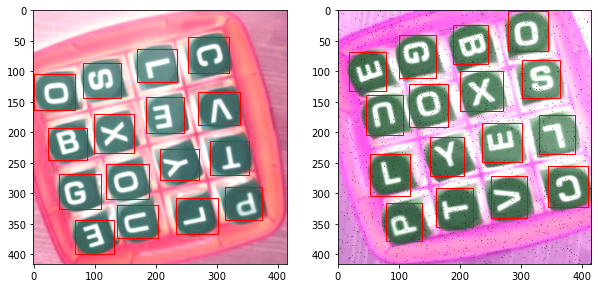

In [35]:
# run as many times as you like to see a new image
img, label, bbox = next(k)
transformed = aug_transform(image = img.permute(1, 2, 0).detach().numpy(), bboxes = bbox, class_labels = label)

tformed_img = torch.Tensor(transformed['image'])
tformed_bbox =np.int64(np.array(transformed['bboxes'] ))

# set up plot
fig, ax = plt.subplots(1,2, figsize = (10, 10))
ax[0].imshow(img.permute(1,2,0))
ax[1].imshow(tformed_img.permute(1,2, 0))

# transformed image
for bb in tformed_bbox:
    rectangle = pac.Rectangle(
        (bb[0], bb[1]),
        bb[2],
        bb[3],
        fc = 'none',
        ec='red')
    ax[1].add_patch(rectangle)

# original image (from pipeline - already transformed)
for bb in bbox:
    rectangle = pac.Rectangle(
        (bb[0], bb[1]),
        bb[2],
        bb[3],
        fc = 'none',
        ec='red')
    ax[0].add_patch(rectangle)
plt.show();

In [12]:
# make the network
class ObjectDetector(nn.Module):

    def __init__(self, num_objects):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 1, 16)
        self.pool = nn.MaxPool2d(8, 8)
        # bbox regressor
        self.fc1 = nn.Linear(2500, 1024)
        self.fc2 = nn.Linear(1024, 512)
        self.fc3 = nn.Linear(512, 4 * num_objects)
        self.fc4 = nn.Linear(4 * num_objects, 4 * num_objects)

    def forward(self,x):
        x = torch.relu(self.conv1(x))
        x = self.pool(x)
        x = torch.flatten(x, 1) # all dimensions except for batch
        x = torch.relu(self.fc1(x))
        x = torch.relu(self.fc2(x))
        x = torch.relu(self.fc3(x))
        x = torch.relu(self.fc4(x)) # try to teach model about bbox overlaps
        return x


# try using resnet pretrained model - takes a lot of memory
class resnet_ObjectDetector(nn.Module):

    def __init__(self, base_mod, num_objects):
        super().__init__()
        self.base_mod = base_mod
        self.fc1 = nn.Linear(1000, 4 * num_objects)


    def forward(self,x):
        x = self.base_mod(x)
        x = torch.relu(self.fc1(x))
        return x

In [35]:
# create training function to play with hyperparams
# def train(net, epochs, trainloader, criterion, optimizer, k = 10):
#     # train the network
#     results = dict()
#     for epoch in range(epochs):

#         running_loss = 0.0
#         for i, data in enumerate(trainloader, 0):
#             # get the inputs; data is a list of [inputs, labels]
#             inputs, labels, bbox = data

#             # zero the parameter gradients (still not sure what this is really?)
#             optimizer.zero_grad()

#             # forward + backward + optimize
#             outputs = net(inputs.float())
#             loss = criterion(outputs, torch.flatten(bbox,1))
#             loss.backward()
#             optimizer.step()

#             # print stats
#             running_loss += loss.item()

#         if epoch % k == 0: # print every k epochs
#             print(f'{epoch + 1} loss: {running_loss:.3f}')

#         results[epoch] = running_loss
#         running_loss = 0.0 # reset at end of each epoch


#     print('Finished Training')
#     return results
def train(net, dataloader, criterion, optimizer):
    # train the network
    running_loss = 0.0
    for i, data in enumerate(dataloader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels, bbox = data

        # zero the parameter gradients (still not sure what this is really?)
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = net(inputs.float())
        loss = criterion(outputs, torch.flatten(bbox,1))
        loss.backward()
        optimizer.step()

        # print stats
        running_loss += loss.item()

    return running_loss


def validation(net, dataloader, criterion):
    running_loss = 0
    with torch.no_grad():
        for i, data in enumerate(dataloader, 0):
            # get the inputs; data is a list of [inputs, labels]
            inputs, labels, bbox = data

            # forward + backward + optimize
            outputs = net(inputs.float())
            loss = criterion(outputs, torch.flatten(bbox,1))

            # print stats
            running_loss += loss.item()
    return running_loss

def train_and_validate(net, epochs, trainloader, validloader, criterion, optimizer, k = 10):
    train_results = dict()
    valid_results = dict()
    for epoch in range(epochs):
        train_results[epoch] = train(net, trainloader, criterion, optimizer)
        valid_results[epoch] = validation(net, validloader, criterion)

        if epoch % k == 0:
            print(f'EPOCH: {epoch + 1} training loss: {train_results[epoch]:.3f} validation loss: {valid_results[epoch]:.3f}')
    return {'train':train_results, 'valid':valid_results}


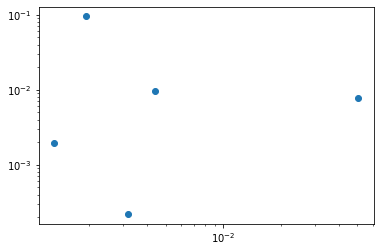

In [34]:
# set up a random grid of values for tuning - range 0.0001 to 1
learning_rates = 10 ** (-4 * np.random.rand(5))
decay =  10 ** (-4 * np.random.rand(5))

# sampled uniformly from log space
fig = plt.figure()
ax = plt.gca()
ax.scatter(decay, learning_rates)
ax.set_yscale('log')
ax.set_xscale('log')

In [25]:
net = ObjectDetector(16)
criterion = nn.MSELoss() 
optimizer = optim.Adam(net.parameters(), lr = 0.001) 
model_results = train_and_validate(net, 3, trainDL, testDL, criterion, optimizer, k = 10)
pd.DataFrame(model_results).plot()

1
training loss: 97278.895
validation loss: 18475.754
--------------------

2
training loss: 81925.623
validation loss: 23629.123
--------------------

3
training loss: 88262.711
validation loss: 20509.879
--------------------



In [29]:
from torchvision.models import resnet18

resnet = resnet18(weights = 'ResNet18_Weights.IMAGENET1K_V1')

In [30]:
net = resnet_ObjectDetector(resnet, 16)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001) 
model_results = train_and_validate(net, 60, trainDL, testDL, criterion, optimizer, k = 10)
pd.DataFrame(model_results).plot();

1
training loss: 79744.795
validation loss: 20187.922
--------------------



In [36]:
# k = iter(testFiles)
k = iter(trainFiles)

In [59]:
def createBBoxPlot(bboxes, color = 'red'):
    """Sets out a series of bounding boxes and adds to an existing plot"""
    for bb in bboxes:
        rectangle = pac.Rectangle(
            (bb[0], bb[1]),
            bb[2],
            bb[3],
            fc = 'none',
            ec=color)
        plt.gca().add_patch(rectangle)

def bboxPlot(img, true_bb, pred_bb = False, prediction = False):
    """
    Creates an image plot with a base image and associated bounding boxes. If modelling, create predicted bboxes as well.
    """

    # plot the image
    plt.axes()
    plt.imshow(
        img.detach().numpy(),
        cmap = 'Greys'
    )

    createBBoxPlot(true_bb)

    if prediction:
        createBBoxPlot(pred_bb, 'green')
    
    plt.show()

def plotODResults(img, bbox, net = False, prediction = False):
    """
    takes image and bbox, network and prediction optional - but both must be present to run prediction.
    net is False, or a pytorch network
    """

    if prediction:
        pred_bbox = net(img.float())
        print(type(img), img.squeeze().permute(1, 2, 0).size())
        bboxPlot(
            img = img.squeeze().permute(1, 2, 0), 
            true_bb = bbox, 
            pred_bb = pred_bbox.detach().numpy().reshape(16, 4),
            prediction = prediction
            )
    else:
        bboxPlot(img, bbox)



<class 'torch.Tensor'> torch.Size([416, 416, 3])


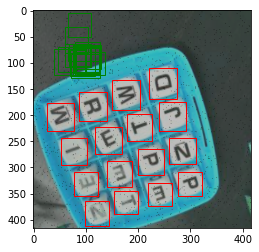

In [70]:
img, _, bbox = next(k)

plotODResults(img[None, : ], bbox, net, prediction = True)

In [154]:
img, _, bbox = next(k)

net(img.float()).reshape(16, 4)

tensor([[ 6.8484,  7.1832,  4.2265,  3.1379],
        [ 7.7249,  5.0412,  5.3384,  4.6215],
        [ 8.3518,  7.0498,  0.0000,  4.6855],
        [ 6.7926,  6.5522,  3.9072,  3.1630],
        [ 7.0298, 10.5696,  5.0591,  4.9373],
        [ 3.7256, 13.0280,  0.0000,  6.7788],
        [ 8.4953,  7.2208,  0.0000,  0.0000],
        [ 8.2304,  7.0293,  4.9867,  1.5203],
        [ 9.3885,  9.9623,  4.4939,  4.2805],
        [ 7.9176,  5.9234,  6.2717,  2.7782],
        [ 0.0000,  7.4417,  5.2536,  4.8608],
        [ 6.6167,  6.3601,  4.3407,  4.7660],
        [ 0.0000,  6.9326,  3.2186,  3.2781],
        [ 6.9665, 10.1498,  3.8504,  8.0338],
        [ 7.5201,  8.1083,  0.0000,  5.0009],
        [ 8.2668,  6.3487,  0.0000,  1.9514]], grad_fn=<ReshapeAliasBackward0>)

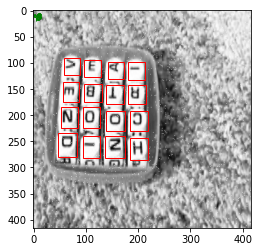

In [156]:

plotODResults(img.float(), bbox, net, prediction = True)

In [577]:

img, _, bbox = next(k)
type(img)
pred = net(img)
pred_bb = pred.detach().numpy().reshape(16, 4)
plt.axes()
plt.imshow(img.detach().numpy().sum(axis = 0).reshape(416, 416), cmap = 'Greys')

# predictions
for bb in pred_bb:
        rectangle = pac.Rectangle(
            (bb[0], bb[2]),
            abs(bb[1] - bb[0]),
            abs(bb[3] - bb[2]),
            fc = 'none',
            ec="red")
        plt.gca().add_patch(rectangle)
# actual
for bb in bbox:
        rectangle2 = pac.Rectangle(
            (bb[0], bb[2]),
            abs(bb[1] - bb[0]),
            abs(bb[3] - bb[2]),
            fc = 'none',
            ec="green")
        plt.gca().add_patch(rectangle2)
plt.show()    

TypeError: conv2d() received an invalid combination of arguments - got (tuple, Parameter, NoneType, tuple, tuple, tuple, int), but expected one of:
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, tuple of ints padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)
 * (Tensor input, Tensor weight, Tensor bias, tuple of ints stride, str padding, tuple of ints dilation, int groups)
      didn't match because some of the arguments have invalid types: (!tuple!, !Parameter!, !NoneType!, !tuple!, !tuple!, !tuple!, int)


In [256]:
k = iter(trainDS)
image, label, bbox = next(k)

od = ObjectDetector(16)
res = od(image)
print(res)
# plt.imshow(res.detach().numpy().reshape(8, 8))

tensor([[0.1148, 0.1334, 0.0276, 0.0709, 0.0097, 0.0000, 0.3450, 0.0974, 0.0000,
         0.0889, 0.0000, 0.0000, 0.0311, 0.0000, 0.4364, 0.2964, 0.0000, 0.0000,
         0.0000, 0.0000, 1.0915, 0.2705, 0.3431, 0.0000, 0.1172, 0.3473, 0.0000,
         0.0000, 0.1433, 0.2279, 0.6779, 0.0000, 0.0000, 0.1145, 0.5016, 0.0318,
         0.1407, 0.0000, 0.0000, 0.5247, 0.0000, 0.1287, 0.0000, 0.0000, 0.0000,
         0.5387, 0.2347, 0.1974, 0.4336, 0.0000, 0.0000, 0.0000, 0.0000, 0.2718,
         0.0000, 0.0000, 0.0000, 0.0000, 0.2156, 0.1745, 0.0000, 0.0000, 0.0000,
         0.4327]], grad_fn=<ReluBackward0>)


In [579]:
from torchvision.models import resnet18

resnet = resnet18(weights = 'ResNet18_Weights.IMAGENET1K_V1')



Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\61417/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:07<00:00, 6.66MB/s]


In [580]:
net = resnet_ObjectDetector(resnet, 16)
criterion = nn.MSELoss()
optimizer = optim.Adam(net.parameters(), lr = 0.001, weight_decay=0.00001) 
model_results = train(net, 1, trainDL, criterion, optimizer, k = 1)

1 loss: 127184.695
Finished Training


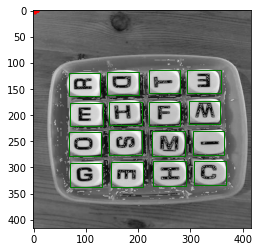

In [605]:
img, _, bbox = next(k)
type(img)

pred = net(img[None, :])
pred_bb = pred.detach().numpy().reshape(16, 4)
plt.axes()
plt.imshow(img.detach().numpy().sum(axis = 0).reshape(416, 416), cmap = 'Greys')

# predictions
for bb in pred_bb:
        rectangle = pac.Rectangle(
            (bb[0], bb[2]),
            abs(bb[1] - bb[0]),
            abs(bb[3] - bb[2]),
            fc = 'none',
            ec="red")
        plt.gca().add_patch(rectangle)
# actual
for bb in bbox:
        rectangle2 = pac.Rectangle(
            (bb[0], bb[2]),
            abs(bb[1] - bb[0]),
            abs(bb[3] - bb[2]),
            fc = 'none',
            ec="green")
        plt.gca().add_patch(rectangle2)
plt.show()    

